# The Bernstein-Vazirani Algorithm

In this tutorial, we implement the Bernstein-Vazirani algorithm on a simulator as well as two quantum devices, using the Amazon Braket SDK. The Bernstein-Vazirani algorithm, developed by Ethan Bernstein and Umesh Vazirani in 1992, was originally designed as an example of a quantum algorithm that is provably distinct in its computational complexity from its classical counterpart. However, because of its structure, it is also a useful tool to understand the performance of today's hardware.

## The Problem

For $f(x) = x \cdot s = x_1s_1 + x_2s_2 + \cdots + x_ns_n $, find $s$.

In practice, this means that we have some secret bitstring $s$ that will be encoded in an oracle function $f$, and a promise that $f(x)$ is the bitwise dot product of $x$ and $s$.

## The Classical Algorithm

Classically, we can ascertain $s$ in O(N), by determining each bit of $s$ individually. Because $f_s(x) = s \cdot x$ mod $2$, an input of $x$ = 1000...0 will show the least significant bit of $x$, $x$ = 0100...0 will show us the next-least-significant bit, and so-on, to 0000...1, for a total of N calls to the oracle. 

## The Quantum Algorithm

Our quantum solution can ascertain $s$ in O(1), that is, after only a single call to the oracle function. 

To do this, we
- initialize $N$ qubits to the `|0⟩` state.
- apply a Hadamard gate to all qubits
- query our oracle $f$
- apply a Hadamard gate to all qubits
- measure

Generalized, this circuit looks like the following, where $U_f$ is our query.
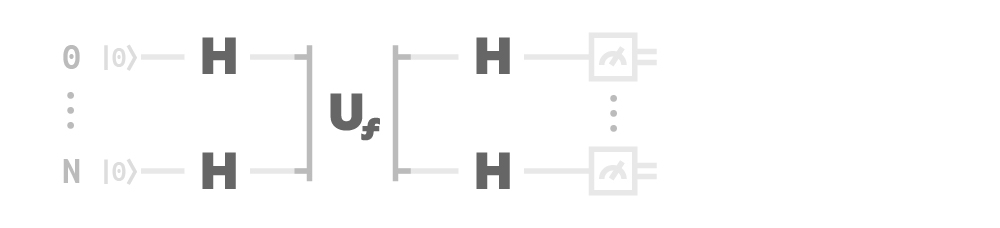

## Implementation

To implement this algorithm in hardware, we "peek inside the oracle" and choose $s$ ahead of time. We then encode this oracle as a series of `cnot` gates — for each qubit $i$, if $s_i$ is a `1` we add a `cnot` with a control of qubit `i` and an ancilla initialized to `|-⟩` with an `X` gate as the target, thus using using phase kickback to add a phase of $\pi$ for each input qubit where $s_i=1$.

The circuit for a simple example, where `s` is `11`, would look like this:
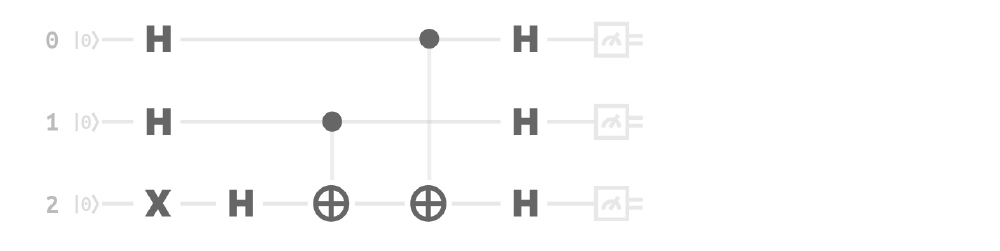

Because this implementation requires entangling as many as all of the qubits in the register with the ancilla qubit, and successfully performing multiple single-qubit rotations on each qubit, it also serves a reasonable test of quantum computer perfomance, where we can generally expect systems with more complete connectivity to outperform ones with more restricted connectivity, because the additional `SWAP` overhead required to make all of the input qubits 'talk' to the ancilla will introduce additonal noise into the computation.

Now, let's implement in code using the Braket SDK.

## Imports and Setup

First, we'll do some setup that will allow us to build, visualize, store, and retrieve the circuits we'll be running via the Braket SDK.

In [301]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import math
import time

# magic invocation for producing visualizations in notebook
%matplotlib inline

In [302]:
# AWS imports: Import Braket SDK modules
import boto3
from braket.circuits import circuit, Circuit, Gate, Moments
from braket.circuits.instruction import Instruction
from braket.devices import LocalSimulator
from braket.aws import AwsQuantumTask, AwsDevice

In [303]:
# set up S3 bucket (where results are stored). Change the bucket_name to the S3 bucket you created.
aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
#my_bucket = f"amazon-braket-{aws_account_id}" # the name of the bucket
#my_prefix = "simulation-output" # the name of the folder in the bucket
my_bucket = "amazon-braket-output-coleman" # the name of the bucket
my_prefix = "simulation-output" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

## Building the Circuit

Rather than manually building the BV circuit every time, we'll create a method that can build one for any $s$ and any register size.

In [304]:
def make_bv_circuit(s_int, input_size):
    """build the Bernstein-Vazirani circuit
     
    Args:
        s_int (int): value of s as an integer
        input_size (int): size of the input register, 
            i.e. the number of (qu)bits to use for the binary 
            representation of s

    Returns:
        circ (obj): the completed BV circuit

    """
    # confirm the bitstring of S is what we think it should be
    s=('{0:0' + str(input_size) + 'b}').format(s_int)
    print('s:', s)
    
    circ = Circuit()
    # put ancilla in state |-⟩
    circ.x(input_size)
    
    # apply a Hadamard to every qubit before querying the oracle
    for i_qubit in range(input_size+1):
        circ.h(i_qubit)        

    # apply our oracle as a series of cnot gates
    for bit in range(input_size):
        if s[bit]=='1':
            circ.cnot(bit, input_size)
    
    # add Hadamard gates again after querying the oracle
    for i_qubit in range(input_size+1):
        circ.h(i_qubit)
    
    return circ 

We can now build a BV circuit of any size. As an example, let's start with a small BV, featuring five qubits (an input size of five, plus one ancilla), and a target bitstring of `101`, or as an integer, `5`

In [305]:
# make the circuit
s_int = 5
input_size = 3
bv5 = make_bv_circuit(s_int, input_size)

# print the circuit to confirm it was built as expected
print(bv5)

s: 101
T  : |0|1|2|3|4|
                
q0 : -H---C-H---
          |     
q1 : -H-H-|-----
          |     
q2 : -H---|-C-H-
          | |   
q3 : -X-H-X-X-H-

T  : |0|1|2|3|4|


## Local Simulation

Now, let's run our circuit using the local simulator. It's useful to first test a small version on a simulator before running it on the actual quantum device, to make sure it's behaving as expected, and for fast experiments with low-to-intermediate qubit numbers ($N<20-25$), the local simulator is the preferred choice.

In [306]:
# set up device: Local Simulator.
device = LocalSimulator()

By default, the circuit will only return its results as counts. If we want to see probabilities or the full state vector (the state vector is only available from the simulator), we must append the desired result types before running the circuit.

With a larger qubit register, printing the full probability distribution can become overwhelming, and it's often bettter to just show the distribution of nonzero output strings, but we'll show how to do it here while we're still only dealing with 16 possible output strings. 

In [307]:
# append the probability result type
bv5.probability();

In [308]:
# run the circuit
result = device.run(bv5, shots=1000).result()
# get measurment counts
counts = result.measurement_counts
# print counts
print('counts:', counts)

counts: Counter({'1011': 1000})


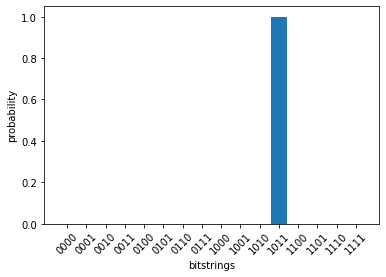

In [309]:
# set up values for plot
num_qubits = bv5.qubit_count
format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]
probabilities = result.values[0]

# plot full probability distribution
plt.bar(bitstring_keys, probabilities);
plt.xlabel('bitstrings');
plt.ylabel('probability');
plt.xticks(rotation=45);

## Cloud-Based Simulation

We also have the option of running our circuit on the Braket cloud-based simulator. This is ideal for large simulation jobs (jobs with many highly-entangled qubits) where memory-optimized cloud hardware will be more performant than a local machine. 

Here, the `run()` method must also include an S3 location where the job will be stored. This is the `s3_folder` we initialized at the top of the notebook.

In [310]:
# set up device
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

In [311]:
# define a larger BV circuit
s_int = 999
input_size = 10
bv999 = make_bv_circuit(s_int, input_size)

# visualize the circuit
print(bv999)

s: 1111100111
T   : |0|1|2|3|4|5|6|7|8|9|10|
                              
q0  : -H---C-H----------------
           |                  
q1  : -H---|-C-H--------------
           | |                
q2  : -H---|-|-C-H------------
           | | |              
q3  : -H---|-|-|-C-H----------
           | | | |            
q4  : -H---|-|-|-|-C-H--------
           | | | | |          
q5  : -H-H-|-|-|-|-|----------
           | | | | |          
q6  : -H-H-|-|-|-|-|----------
           | | | | |          
q7  : -H---|-|-|-|-|-C-H------
           | | | | | |        
q8  : -H---|-|-|-|-|-|-C-H----
           | | | | | | |      
q9  : -H---|-|-|-|-|-|-|-C-H--
           | | | | | | | |    
q10 : -X-H-X-X-X-X-X-X-X-X-H--

T   : |0|1|2|3|4|5|6|7|8|9|10|


In [312]:
# run BV circuit on cloud simulator
simulator_job = device.run(bv999, s3_folder, shots=1000, poll_timeout_seconds=24*60*60)

Because the cloud simulator is a remote resource, it may take a short while for our job to complete. We can request its status from the SDK, and once we can see that it's finished, proceed to examine the results.

In [313]:
# Get ID of job
simulator_job_id = simulator_job.id
print('Job ID :', simulator_job_id)

# Wait for job to complete
status_list = []
status = simulator_job.state()
status_list += [status]
print('Status:', status)

# Print when there's a status change until job is completed
while status != 'COMPLETED':
    time.sleep(1) # wait a second at the top of each loop so we're not hammering the API
    status = task.state()
    if status != status_list[-1]:
        print('Status:', status)
    status_list += [status]

Job ID : arn:aws:braket:us-east-1:843596884203:quantum-task/6c9ca951-4dac-4bc6-9e86-6a8cbd34f42a
Status: COMPLETED


Once our job is completed, we can examine and plot (or otherwise post-process) the results as desired.

Counter({'11111001111': 1000})


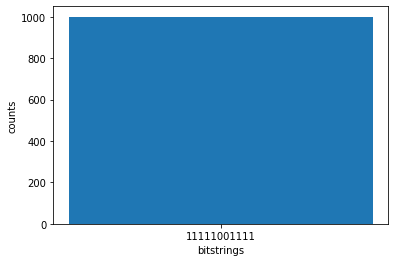

In [314]:
counts = simulator_job.result().measurement_counts
print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

## Quantum Hardware: Rigetti

Now let's try running our circuit on real quantum hardware. First the Aspen superconducting chip provided by Rigetti. Because we're limited by hardware availaility, our job may not run immediately, and may instead be queued to run on this device at some point in the future. While we may have to wait for some time for our circuit to be run, asynchronous execution allows us to perform other tasks and come back later to check its status, rather than being blocked until it's executed. 

In [315]:
# set up device
rigetti = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-8")

# run circuit with a polling time of 5 days
rigetti_job = rigetti.run(bv999, s3_folder, shots=100, poll_timeout_seconds=5*24*60*60)

# get id and status of submitted task
rigetti_job_id = rigetti_job.id
rigetti_job_status = rigetti_job.state()
print('Job ID:', rigetti_job_id)
print('Job status:', rigetti_job_status)

Job ID: arn:aws:braket:us-west-1:843596884203:quantum-task/644ff18e-180e-4ea5-984a-a109c9ca2a80
Job status: CREATED


Now that the job has been created, we can check its status by running the below cell (re-running the above cell would submit an entirely new job). See below for examples of logic for proceed with further analysis and visualization once the job is complete.

In [316]:
# get id and status of submitted task
rigetti_job_id = rigetti_job.id
rigetti_job_status = rigetti_job.state()
print('Job ID:', rigetti_job_id)
print('Job status:', rigetti_job_status)

Job ID: arn:aws:braket:us-west-1:843596884203:quantum-task/644ff18e-180e-4ea5-984a-a109c9ca2a80
Job status: CREATED


## Quantum Hardware: IonQ

Now, let's submit the same circuit to IonQ's trapped ion system.

In [317]:
# set up device
ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

# run circuit with a polling time of 5 days
ionq_job = ionq.run(bv999, s3_folder, shots=100, poll_timeout_seconds=5*24*60*60)

# get id and status of submitted task
ionq_job_id = ionq_job.id
ionq_job_status = ionq_job.state()

print('Job ID:', ionq_job_id)
print('Job status:', ionq_job_status)

Job ID: arn:aws:braket:us-east-1:843596884203:quantum-task/28666700-888f-4374-8e2a-c6f49d45cc1b
Job status: CREATED


Now that the job has been created, we can check its status by running the below cell (re-running the above cell would submit an entirely new job). See below for examples of logic for proceed with further analysis and visualization once the job is complete.

In [318]:
# get id and status of submitted task
ionq_job_id = ionq_job.id
ionq_job_status = ionq_job.state()

print('Job ID:', ionq_job_id)
print('Current status:', ionq_job_status)

Job ID: arn:aws:braket:us-east-1:843596884203:quantum-task/28666700-888f-4374-8e2a-c6f49d45cc1b
Current status: CREATED


## Retrieving Jobs

Once the job has been submitted, you can retrieve its status and, if it has been run, its results and other metadata using its unique job ID. First, let's create a helper method to retrieve and print the details of any job we have the ID for.

In [319]:
def retrieve_job(job_id):
    """retrieves job and graphs output and metadata if completed
    Args:
        job_id (str): the job ID (arn) we wish to retrieve

    Returns:
        retrieved (obj): the recovered job
    """
    # recover task
    retrieved = AwsQuantumTask(arn=job_id)

    # check status
    status = retrieved.state()
    print('Status of retrieved job:', status)

    # wait for job to complete
    # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
    if status == 'COMPLETED':
        # get results
        results = retrieved.result()
        # print(results)

        # get all metadata
        metadata = retrieved.metadata()
        # example for metadata
        shots = metadata['shots']
        machine = metadata['deviceArn']
        # print example metadata
        print("{} shots taken on machine {}.\n".format(shots, machine))

        # get measurement counts
        counts = results.measurement_counts
        print('Measurement counts:', counts)

        # plot results: see algorithm accuracy
        plt.bar(counts.keys(), counts.values());
        plt.xlabel('bitstrings');
        plt.ylabel('counts');
        plt.xticks(rotation=45);
        plt.tight_layout();
    
        return retrieved
                
    elif status in ['FAILED', 'CANCELLED']:
        # print terminal message 
        print('Your job has either failed or been cancelled.')

    else:
        # print current status
        print('Sorry, your job is still being processed. Try again later.')

Now, let's retrieve the Rigetti job and see its output

Status of retrieved job: COMPLETED
100 shots taken on machine arn:aws:braket:::device/qpu/rigetti/Aspen-8.

Measurement counts: Counter({'10111001111': 2, '10110000100': 2, '00101110101': 2, '00010100000': 1, '00000100101': 1, '00111100100': 1, '11000001110': 1, '11100000101': 1, '10010001100': 1, '10001100111': 1, '00100010101': 1, '00111001100': 1, '10111000010': 1, '00010100101': 1, '01001101100': 1, '00111100010': 1, '10111100111': 1, '00110111111': 1, '11000100100': 1, '11110100110': 1, '10010100101': 1, '00111111110': 1, '10101011001': 1, '11000100111': 1, '00111000111': 1, '00000100111': 1, '10100100101': 1, '00100100010': 1, '11111110001': 1, '11011011011': 1, '00001011011': 1, '00010100110': 1, '10101100100': 1, '00101100101': 1, '01111100010': 1, '01111001110': 1, '01111110100': 1, '10000011100': 1, '00111110100': 1, '00011000110': 1, '10000100010': 1, '11101001001': 1, '11010101111': 1, '00000101001': 1, '00110000000': 1, '01000100100': 1, '01011000100': 1, '00010010000': 1,

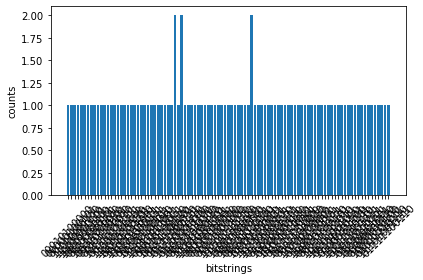

In [334]:
retrieved_rigetti = retrieve_job(rigetti_job_id)

Next, let's retrieve the results from the IonQ system.

Status of retrieved job: COMPLETED
100 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.

Measurement counts: Counter({'11111001111': 98, '11110001111': 1, '11111101111': 1})


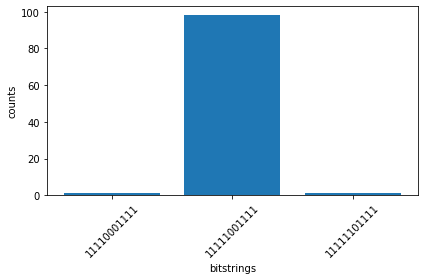

In [335]:
retrieved_ionq = retrieve_job(ionq_job_id)

The accuracy of the quantum computer for this algorithm corresponds to the number of shots for the ideal bitstring—the input bitstring appended with a 1 from the ancilla qubit—divided by the total number of shots. We can find out how each system did by comparing it to our simulation results, which returned the ideal bitstring 100% of the time. We'll use the probability output so that we don't need to worry about scaling to different shot counts.

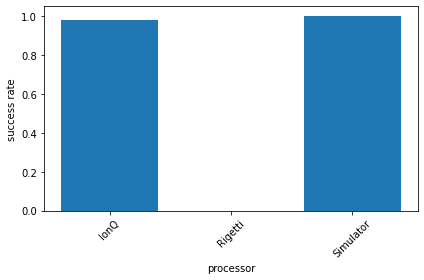

In [336]:
ionq_probabilities = retrieved_ionq.result().measurement_probabilities
rigetti_probabilities = retrieved_rigetti.result().measurement_probabilities
simulator_probabilities = simulator_job.result().measurement_probabilities

def safe_lookup(d, k):
    """gets value at key, catches KeyError and returns zero if doesn't exist in dict
    Args:
        d: the dict to look in
        k: the key to look for 
    Returns:
        lookup: item in question, or zero if key doesn't exist
    """
    try:
        lookup = d[k]
    except KeyError:
        lookup = 0
    return lookup

ideal_bitstring = '11111001111'

processors = ['IonQ', 'Rigetti', 'Simulator']
success_rates = [ safe_lookup(ionq_probabilities, ideal_bitstring), safe_lookup(rigetti_probabilities,ideal_bitstring), safe_lookup(simulator_probabilities, ideal_bitstring)]
x_pos = [i for i, _ in enumerate(processors)]

plt.bar(x_pos, success_rates);
plt.xlabel('processor');
plt.ylabel('success rate');
plt.xticks(x_pos, processors, rotation=45);
plt.tight_layout();